<a href="https://colab.research.google.com/github/ujs/cifar10/blob/master/cifar10_keras_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Different models that will be implemented in this notebook
*   model1- Baseline - VGG 3  (visual geometry group)
*   model2- Baseline + Regularization (dropout + weight decay)



In [1]:
#Importing libraries
from matplotlib import pyplot as plt
import pandas as pd
from keras import layers
from keras import models
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from keras import regularizers

Using TensorFlow backend.


In [2]:


#importing data
from keras.datasets import cifar10

#load data
(x, y),(x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [3]:
#examine shape of data
print (x.shape)
print (x_test.shape)
print (y.shape)
print (y_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 1)
(10000, 1)


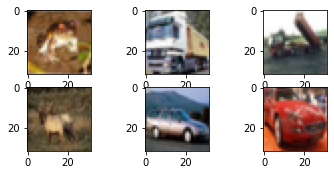

In [4]:
#See a few images in the data set
for i in range(6):
  plt.subplot(330 + 1 + i)
  plt.imshow(x[i])
plt.show()

In [0]:
#Splitting x,y data into train and validation data
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=1)



In [70]:

print(x_train.shape)
print(x_val.shape)

(40000, 32, 32, 3)
(10000, 32, 32, 3)


In [0]:
#Data Preprocessing

#one-hot encode target values
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)


#Rescaling images 

train_datagen = ImageDataGenerator (rescale = 1./255)
val_datagen = ImageDataGenerator (rescale = 1./255)
test_datagen = ImageDataGenerator (rescale = 1./255)

train_generator = train_datagen.flow(x_train, y_train,batch_size = 64)
val_generator = val_datagen.flow(x_val, y_val)



In [8]:
# model1- baseline VGG 3
def baseline():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation ='relu', kernel_initializer='he_uniform', padding = 'same', input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding = 'same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding = 'same'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding = 'same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding = 'same'))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding = 'same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(layers.Dense(10, activation='softmax'))
  # compile model
  opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

#Instatiating model
model1 = baseline()
model1.summary()







Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)  

In [0]:
#Fitting baseline model
steps = x_train.shape[0]/64
history = model1.fit_generator(train_generator, steps_per_epoch = steps, epochs = 60, validation_data = val_generator)
model1.save('cifar10_baseline')

In [13]:
# evaluate model
	_, acc = model1.evaluate(val_generator, verbose=0)
	print((acc * 100.0))


71.15


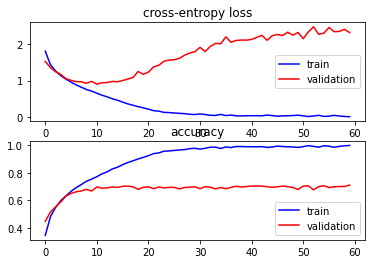

In [12]:
#Plotting 

#Plot loss
plt.subplot(211)
plt.title('cross-entropy loss')
plt.plot(history.history['loss'],color = 'blue', label = 'train')
plt.plot(history.history['val_loss'], color = 'red', label = 'validation')
plt.legend()

#plot accurcay
plt.subplot(212)
plt.title('accuracy')
plt.plot(history.history['acc'],color = 'blue', label = 'train')
plt.plot(history.history['val_acc'], color = 'red', label = 'validation')
plt.legend()


In [0]:
# Function to try out different models

def test_model(model):
  #Instantiate model
  model = model()

  #fit model
  steps = x_train.shape[0]/64
  history = model.fit_generator(train_generator, steps_per_epoch = steps, epochs = 80, validation_data = val_generator)
  model.save('cifar10_{}'.format(model))

  #Plot loss
  plt.subplot(211)
  plt.title('cross-entropy loss')
  plt.plot(history.history['loss'],color = 'blue', label = 'train')
  plt.plot(history.history['val_loss'], color = 'red', label = 'validation')
  plt.legend()

  #plot accurcay
  plt.subplot(212)
  plt.title('accuracy')
  plt.plot(history.history['acc'],color = 'blue', label = 'train')
  plt.plot(history.history['val_acc'], color = 'red', label = 'validation')
  plt.legend()

  # evaluate model
  _, acc = model.evaluate(val_generator, verbose=0)
  print('> %.3f' % (acc * 100.0))
  return acc


In [0]:
# model2- Baseline + Regularization (dropout + weight decay)
def model2():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation ='relu', kernel_initializer='he_uniform', padding = 'same', kernel_regularizer=regularizers.l2(0.001), input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding = 'same', kernel_regularizer=regularizers.l2(0.001)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding = 'same', kernel_regularizer=regularizers.l2(0.001)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding = 'same', kernel_regularizer=regularizers.l2(0.001)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding = 'same', kernel_regularizer=regularizers.l2(0.001)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding = 'same', kernel_regularizer=regularizers.l2(0.001)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(0.001)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(10, activation='softmax'))
  # compile model
  opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

#testing
test_model(model2)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/80
625/625 [==============================] - 321s 514ms/step - loss: 3.1571 - acc: 0.2521 - val_loss: 2.8689 - val_acc: 0.3762
Epoch 2/80
625/625 [==============================] - 321s 513ms/step - loss: 2.8182 - acc: 0.3669 - val_loss: 2.6586 - val_acc: 0.4290
Epoch 3/80
625/625 [==============================] - 319s 510ms/step - loss: 2.6456 - acc: 0.4296 - val_loss: 2.5141 - val_acc: 0.4749
Epoch 4/80
625/625 [==============================] - 316s 505ms/step - loss: 2.5181 - acc: 0.4665 - val_loss: 2.3908 - val_acc: 0.5240
Epoch 5/80
625/625 [==============================] - 315s 504ms/step - loss: 2.4135 - acc: 0.5016 - val_loss: 2.2797 - val_acc: 0.5563
Epoch 6/80
625/625 [==============================] - 316s 505ms/step - loss: 2.3286 - acc: 0.5274 - val_loss: 2.1910 - val_acc: 0.5845
Epoch 7/80
625/625 [==============================] - 316s 506ms/ste

In [0]:
# model3- Baseline + Data Augmentation

def model3():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation ='relu', kernel_initializer='he_uniform', padding = 'same', input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding = 'same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding = 'same'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding = 'same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding = 'same'))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding = 'same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(layers.Dense(10, activation='softmax'))
  # compile model
  opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

#data augmentation
train_datagen = ImageDataGenerator (rescale = 1./255, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip = True)
train_generator = train_datagen.flow(x_train, y_train,batch_size = 64)


#testing
test_model(model3)

In [0]:
#model4- Baseline + Dropout + Data Augmentation
def model4():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation ='relu', kernel_initializer='he_uniform', padding = 'same', input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding = 'same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding = 'same'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding = 'same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding = 'same'))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding = 'same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(10, activation='softmax'))
  # compile model
  opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

#data augmentation
train_datagen = ImageDataGenerator (rescale = 1./255, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip = True)
train_generator = train_datagen.flow(x_train, y_train,batch_size = 64)

#testing
test_model(model4)


In [0]:
#model5- Baseline + Dropout + Data Augmentation + Batch Normalization
def model4():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation ='relu', kernel_initializer='he_uniform', padding = 'same', input_shape=(32, 32, 3)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding = 'same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding = 'same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding = 'same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding = 'same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding = 'same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(10, activation='softmax'))
  # compile model
  opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

#data augmentation
train_datagen = ImageDataGenerator (rescale = 1./255, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip = True)
train_generator = train_datagen.flow(x_train, y_train,batch_size = 64)

#testing
test_model(model5)
